In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [18]:
data = pd.read_csv("data1.csv")
data["Speed (GPS)(km/h)"] = data["Speed (GPS)(km/h)"].replace(["-"], [0])
data_speed = data[["GPS Time", " Device Time", "Speed (GPS)(km/h)", "Speed (OBD)(km/h)"]]

data_speed["GPS Time"] = data_speed["GPS Time"].map(lambda x : x.split()[3])
data_speed[" Device Time"] = data_speed[" Device Time"].map(lambda x : x.split()[1])

C:\Users\Davidka\AppData\Local\Temp\ipykernel_2200\180613124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_speed["GPS Time"] = data_speed["GPS Time"].map(lambda x : x.split()[3])
C:\Users\Davidka\AppData\Local\Temp\ipykernel_2200\180613124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_speed[" Device Time"] = data_speed[" Device Time"].map(lambda x : x.split()[1])


In [25]:
# Поиск дисперсии для GPS
def varGPS():
    speedGPS = list(map(float, list(data_speed.iloc[:, 2])))
    speedOBD = list(map(float, list(data_speed.iloc[:, 3])))
    m = speedGPS[0]
    n = 0
    var = 0
    for gps, obd in zip(range(len(speedGPS))[::10], range(len(speedOBD))[::10]):
        m = speedGPS[gps]
        var += 1/10 * sum([(i - m)**2 for i in speedOBD[obd: obd + 10]])
        n += 1
    return var/n

16.81660583475493

In [52]:
#Модель скорости
def model(vk1, var1, var2):
    vk = vk1
    var = var1 + var2
    
    return vk, var

# Модель датчика GPS    
def updateGPS(vk, zk, var1, var2):
    vk = (vk * var2)/(var1 + var2) + (zk * var1)/(var1 + var2)
    var = (var1 * var2)/(var1 + var2)
    
    return vk, var

# Модель датчика OBD   
def updateOBD(vk, zk, var1, var2):
    vk = (vk * var2)/(var1 + var2) + (zk * var1)/(var1 + var2)
    var = (var1 * var2)/(var1 + var2)
    
    return vk, var

In [53]:
speedKalman = []


vk = 0
var = 1000
# Рассчет фильтра Калмана
for i, j, speedGPS, speedOBD in np.array(data_speed):
    vk, var = model(vk, var, 0.5)
    
    vk, var = updateGPS(vk, float(speedGPS), var, 17)
        
    vk, var = updateOBD(vk, float(speedOBD), var, 5)
                
    speedKalman.append(vk)
    
data_speed.insert(2, "speedKalman", speedKalman)


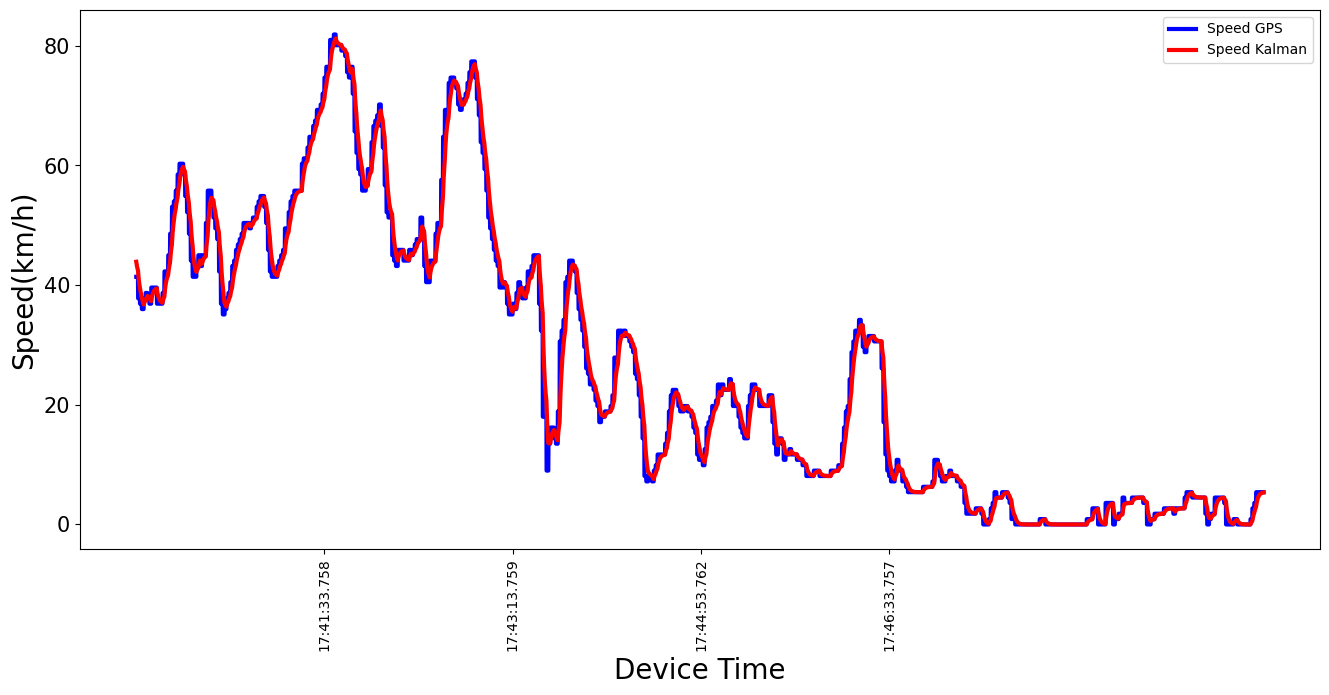

In [6]:
timeGPS = data_speed.iloc[:, 0]
timeOBD = data_speed.iloc[:, 1]
speedKalman = list(map(float, list(data_speed.iloc[:, 2])))
speedGPS = list(map(float, list(data_speed.iloc[:, 3])))
speedOBD = list(map(float, list(data_speed.iloc[:, 4])))

plt.figure(figsize=(16,7))
plt.plot(timeOBD, speedGPS, color="b", label = "Speed GPS", linewidth = 3)
plt.plot(timeOBD, speedOBD, color="g", label = "Speed OBD", linewidth = 3)
plt.plot(timeOBD, speedKalman, color="r", label = "Speed Kalman", linewidth = 3)


plt.legend()
plt.xlabel("Device Time", fontsize = 20)
plt.ylabel("Speed(km/h)", fontsize = 20)

plt.xticks([1000, 2000, 3000, 4000], rotation = 90,  fontsize = 10)
plt.yticks(fontsize = 15)
plt.show()
 

C:\Users\Davidka\AppData\Local\Temp\ipykernel_7424\3069277146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_speed["GPS Time"] = data_speed["GPS Time"].map(lambda x : x.split()[3])


In [8]:
data_speed = data_speed[data_speed["GPS Time"] > "17:25:00"]
data_speed = data_speed[data_speed["GPS Time"] < "17:35:00"]

data_speed = data_speed[data_speed["GPS Time"] > "17:40:00"]
data_speed = data_speed[data_speed["GPS Time"] < "17:50:00"]

,GPS Time,Device Time,speedKalman,Speed (GPS)(km/h),Speed (OBD)(km/h)
4001,17:25:01,17:24:53.758,64.120622,0,64.0
4002,17:25:01,17:24:53.857,64.092585,0,64.0
4003,17:25:01,17:24:53.958,64.071064,0,64.0
4004,17:25:01,17:24:54.060,64.054546,0,64.0
4005,17:25:01,17:24:54.158,64.041867,0,64.0
...,...,...,...,...,...
9986,17:34:59,17:34:52.258,19.821870,0,19.0
9987,17:34:59,17:34:52.358,19.630834,0,19.0
9988,17:34:59,17:34:52.458,19.484202,0,19.0
9989,17:34:59,17:34:52.558,19.371654,0,19.0


In [ ]:



# Функция для инициализации фильтра Калмана
def initialize_kalman_filter(initial_state, initial_covariance, process_noise_variance, measurement_noise_variance,
                             direction_degrees, speed):
    r = 6371 * 1000  # Радиус Земли в метрах
    direction_radians = np.deg2rad(direction_degrees)
    F = np.array([[1, (speed / r) * np.cos(direction_radians)],
                       [0, 1]])
      # Матрица процесса
    H = np.array([[1, 0]])  # Матрица измерений
    Q = np.array([[process_noise_variance]])  # Матрица ковариации процесса
    R = np.array([[measurement_noise_variance]])  # Матрица ковариации измерений
    x = initial_state  # Начальное состояние
    P = initial_covariance  # Начальная ковариация

    return F, H, Q, R, x, P


# Функция обновления состояния и ковариации фильтра Калмана
def update_kalman_filter(F, H, Q, R, x, P, z):
    # Прогноз состояния
    x_pred = np.dot(F, x)
    # Прогноз ковариации
    P_pred = np.dot(np.dot(F, P), F.T) + Q
    # Оценка измерения
    y = z - np.dot(H, x_pred)
    # Ошибка оценки измерения
    S = np.dot(np.dot(H, P_pred), H.T) + R
    # Вычисление калмановского усиления
    K = np.dot(np.dot(P_pred, H.T), np.linalg.inv(S))
    # Коррекция состояния
    x = x_pred + np.dot(K, y)
    # Коррекция ковариации
    P = np.dot((np.eye(len(x)) - np.dot(K, H)), P_pred)

    return x, P


# Загрузка данных из файла
def load_data(file_path):
    data = pd.read_csv(file_path)
    filtered_data = data.drop_duplicates(subset=['GPS Time'])
    filtered_data = filtered_data.loc[filtered_data[" Horizontal Dilution of Precision"] < 20]
    return filtered_data


# Главная функция для оценки расстояния от начальной точки по широте с помощью фильтра Калмана
def estimate_latitude_distance(initial_state, initial_covariance, process_noise_variance,
                               measurement_noise_variance, data):
    # Инициализация фильтра Калмана
    F, H, Q, R, x, P = initialize_kalman_filter(initial_state, initial_covariance, process_noise_variance,
                                                measurement_noise_variance, data[' Bearing'][0], data['GPS Speed ('
                                                                                                    'Meters/second)'][0])

    # Цикл обновления фильтра Калмана
    estimated_latitudes = []
    for index, row in data.iterrows():
        # Измерение широты
        z = row[' Latitude']
        # Обновление фильтра Калмана
        x, P = update_kalman_filter(F, H, Q, R, x, P, z)
        # Оценка широты после коррекции
        estimated_latitude = x[0]
        estimated_latitudes.append(estimated_latitude)

    return estimated_latitudes


# Функция для построения графика зависимости времени от широты
def plot_time_vs_latitude(data, estimated_latitudes):
    plt.plot(data['GPS Time'], estimated_latitudes, label='Оцененная траектория')
    plt.xlabel('Время')
    plt.ylabel('Latitude')
    plt.title('Зависимость времени от широты')
    plt.legend()
    plt.show()
    plt.plot(data['GPS Time'], data[' Latitude'], label='Данные из файла')
    plt.xlabel('Время')
    plt.ylabel('Latitude')
    plt.title('Зависимость времени от широты')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    file_path = "data1.csv"
    data = load_data(file_path)
    initial_state = np.array([0, 0])  # Начальное состояние [latitude_distance,
    # velocity]
    initial_covariance = np.eye(2) * 100  # Начальная ковариация
    process_noise_variance = 0.01  # Дисперсия шума в модели процесса
    measurement_noise_variance = 0.01  # Дисперсия шума в измерениях

    estimated_latitudes = estimate_latitude_distance(initial_state, initial_covariance,
                                                     process_noise_variance, measurement_noise_variance, data)

    plot_time_vs_latitude(data, estimated_latitudes)